# Notebook to calibrate Yolov5

## Imports

In [1]:
pwd

'/home/selim/Desktop/yolov5_multitask/notebooks'

In [2]:
cd ..

/home/selim/Desktop/yolov5_multitask


In [3]:
# Basics
import pandas as pd
import numpy as np

# machine learning
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.models as models
from torchvision.datasets import ImageFolder
# plots
import matplotlib.pyplot as plt
import tkinter
plt.switch_backend('TkAgg')
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
import argparse
import os
import sys
from pathlib import Path
import pandas as pd

import torch
from tqdm import tqdm

from models.common import DetectMultiBackend
from utils.dataloaders import create_classification_dataloader, InfiniteDataLoader
from utils.general import LOGGER, Profile, check_img_size, check_requirements, colorstr, increment_path, print_args
from utils.torch_utils import select_device, smart_inference_mode
import pandas

In [4]:
%matplotlib inline

## Load the data 
### (csv file corresponding to the outputs of a NN)

In [61]:
VAL_PATH = 'runs/val-mlt/exp7/'
WEIGHTS_PATH = 'runs/train-mlt/exp162/weights/best.pt'

In [62]:
#test_results_df = pd.read_csv(r'/home/selim/Desktop/yolov5_multitask/runs/val-cls/exp19/cls_results.csv')
test_results_df = pd.read_csv(f'{VAL_PATH}cls_results.csv')
names=['test_pred', 'test_gt', 'test_prob']
# rename
test_results_df.head()

,test_pred,test_gt,test_prob
0,0,0,0.961295
1,0,0,0.963839
2,0,0,0.971212
3,0,0,0.940915
4,0,0,0.809162


## Define the class names ( ⚠️ to the order)

In [63]:
class_names = ['dry', 'snowy', 'wet']

## Load the corresponding model

In [64]:
device = torch.device("cuda")

In [65]:
model = DetectMultiBackend(WEIGHTS_PATH, device=device, dnn=False, fp16=False)
stride, pt, jit, engine = model.stride, model.pt, model.jit, model.engine
imgsz = check_img_size(224, s=stride)  # check image size
half = model.fp16  # FP16 supported on limited backends with CUDA

Fusing layers... 
YOLOv5s_mlt summary: 163 layers, 7697578 parameters, 0 gradients, 16.4 GFLOPs


In [66]:
model.device

device(type='cuda')

In [67]:
model.__class__.__name__ = 'yolov5s_mlt_512'

## Load the validation dataloader

In [68]:
PATH = f'{VAL_PATH}val_dataset.pth'
val_dataset = torch.load(PATH)

In [69]:
val_dataloader = InfiniteDataLoader(val_dataset, shuffle=False)

## Inspect the calibration of the uncalibrated model

In [70]:
# code from https://github.com/hollance/reliability-diagrams/blob/master/reliability_diagrams.py
def compute_calibration(true_labels, pred_labels, confidences, num_bins=10):
    """Collects predictions into bins used to draw a reliability diagram.
    Arguments:
        true_labels: the true labels for the test examples
        pred_labels: the predicted labels for the test examples
        confidences: the predicted confidences for the test examples
        num_bins: number of bins
    The true_labels, pred_labels, confidences arguments must be NumPy arrays;
    pred_labels and true_labels may contain numeric or string labels.
    For a multi-class model, the predicted label and confidence should be those
    of the highest scoring class.
    Returns a dictionary containing the following NumPy arrays:
        accuracies: the average accuracy for each bin
        confidences: the average confidence for each bin
        counts: the number of examples in each bin
        bins: the confidence thresholds for each bin
        avg_accuracy: the accuracy over the entire test set
        avg_confidence: the average confidence over the entire test set
        expected_calibration_error: a weighted average of all calibration gaps
        max_calibration_error: the largest calibration gap across all bins
    """
    assert(len(confidences) == len(pred_labels))
    assert(len(confidences) == len(true_labels))
    assert(num_bins > 0)

    bin_size = 1.0 / num_bins
    bins = np.linspace(0.0, 1.0, num_bins + 1)
    indices = np.digitize(confidences, bins, right=True)

    bin_accuracies = np.zeros(num_bins, dtype=float)
    bin_confidences = np.zeros(num_bins, dtype=float)
    bin_counts = np.zeros(num_bins, dtype=int)

    for b in range(num_bins):
        selected = np.where(indices == b + 1)[0]
        if len(selected) > 0:
            bin_accuracies[b] = np.mean(true_labels[selected] == pred_labels[selected])
            bin_confidences[b] = np.mean(confidences[selected])
            bin_counts[b] = len(selected)

    avg_acc = np.sum(bin_accuracies * bin_counts) / np.sum(bin_counts)
    avg_conf = np.sum(bin_confidences * bin_counts) / np.sum(bin_counts)

    gaps = np.abs(bin_accuracies - bin_confidences)
    ece = np.sum(gaps * bin_counts) / np.sum(bin_counts)
    mce = np.max(gaps)

    return { "accuracies": bin_accuracies, 
             "confidences": bin_confidences, 
             "counts": bin_counts, 
             "bins": bins,
             "avg_accuracy": avg_acc,
             "avg_confidence": avg_conf,
             "expected_calibration_error": ece,
             "max_calibration_error": mce }


def _reliability_diagram_subplot(ax, bin_data, 
                                 draw_ece=True, 
                                 draw_bin_importance=False,
                                 title="Reliability Diagram", 
                                 xlabel="Confidence", 
                                 ylabel="Expected Accuracy"):
    """Draws a reliability diagram into a subplot."""
    accuracies = bin_data["accuracies"]
    confidences = bin_data["confidences"]
    counts = bin_data["counts"]
    bins = bin_data["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0

    widths = bin_size
    alphas = 0.3
    min_count = np.min(counts)
    max_count = np.max(counts)
    normalized_counts = (counts - min_count) / (max_count - min_count)

    if draw_bin_importance == "alpha":
        alphas = 0.2 + 0.8*normalized_counts
    elif draw_bin_importance == "width":
        widths = 0.1*bin_size + 0.9*bin_size*normalized_counts

    colors = np.zeros((len(counts), 4))
    colors[:, 0] = 240 / 255.
    colors[:, 1] = 60 / 255.
    colors[:, 2] = 60 / 255.
    colors[:, 3] = alphas

    gap_plt = ax.bar(positions, np.abs(accuracies - confidences), 
                     bottom=np.minimum(accuracies, confidences), width=widths,
                     edgecolor=colors, color=colors, linewidth=1, label="Gap")

    acc_plt = ax.bar(positions, 0, bottom=accuracies, width=widths,
                     edgecolor="black", color="black", alpha=1.0, linewidth=3,
                     label="Accuracy")

    ax.set_aspect("equal")
    ax.plot([0,1], [0,1], linestyle = "--", color="gray")
    
    if draw_ece:
        ece = (bin_data["expected_calibration_error"] * 100)
        ax.text(0.98, 0.02, "ECE=%.2f" % ece, color="black", 
                ha="right", va="bottom", transform=ax.transAxes)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    #ax.set_xticks(bins)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.legend(handles=[gap_plt, acc_plt])


def _confidence_histogram_subplot(ax, bin_data, 
                                  draw_averages=True,
                                  title="Examples per bin", 
                                  xlabel="Confidence",
                                  ylabel="Count"):
    """Draws a confidence histogram into a subplot."""
    counts = bin_data["counts"]
    bins = bin_data["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0

    ax.bar(positions, counts, width=bin_size * 0.9)
#     print('CONTAINER', ax.containers[0])
    ax.bar_label(ax.containers[0])
    ax.set_xlim(0, 1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if draw_averages:
        acc_plt = ax.axvline(x=bin_data["avg_accuracy"], ls="solid", lw=3, 
                             c="black", label="Accuracy")
        conf_plt = ax.axvline(x=bin_data["avg_confidence"], ls="dotted", lw=3, 
                              c="#444", label="Avg. confidence")
        ax.legend(handles=[acc_plt, conf_plt])


def _reliability_diagram_combined(bin_data, 
                                  draw_ece, draw_bin_importance, draw_averages, 
                                  title, figsize, dpi, return_fig):
    """Draws a reliability diagram and confidence histogram using the output
    from compute_calibration()."""
    figsize = (figsize[0], figsize[0] * 1.4)

    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=figsize, dpi=dpi, 
                           gridspec_kw={"height_ratios": [4, 1]})

    plt.tight_layout()
    plt.subplots_adjust(hspace=-0.1)

    _reliability_diagram_subplot(ax[0], bin_data, draw_ece, draw_bin_importance, 
                                 title=title, xlabel="")

    # Draw the confidence histogram upside down.
    orig_counts = bin_data["counts"]
    bin_data["counts"] = -bin_data["counts"]
    _confidence_histogram_subplot(ax[1], bin_data, draw_averages, title="")
    bin_data["counts"] = orig_counts

    # Also negate the ticks for the upside-down histogram.
    new_ticks = np.abs(ax[1].get_yticks()).astype(int)
    ax[1].set_yticklabels(new_ticks)    

    plt.show()

    if return_fig: return fig


def reliability_diagram(true_labels, pred_labels, confidences, num_bins=10,
                        draw_ece=True, draw_bin_importance=False, 
                        draw_averages=True, title="Reliability Diagram", 
                        figsize=(6, 6), dpi=72, return_fig=False):
    """Draws a reliability diagram and confidence histogram in a single plot.
    
    First, the model's predictions are divided up into bins based on their
    confidence scores.
    The reliability diagram shows the gap between average accuracy and average 
    confidence in each bin. These are the red bars.
    The black line is the accuracy, the other end of the bar is the confidence.
    Ideally, there is no gap and the black line is on the dotted diagonal.
    In that case, the model is properly calibrated and we can interpret the
    confidence scores as probabilities.
    The confidence histogram visualizes how many examples are in each bin. 
    This is useful for judging how much each bin contributes to the calibration
    error.
    The confidence histogram also shows the overall accuracy and confidence. 
    The closer these two lines are together, the better the calibration.
    
    The ECE or Expected Calibration Error is a summary statistic that gives the
    difference in expectation between confidence and accuracy. In other words,
    it's a weighted average of the gaps across all bins. A lower ECE is better.
    Arguments:
        true_labels: the true labels for the test examples
        pred_labels: the predicted labels for the test examples
        confidences: the predicted confidences for the test examples
        num_bins: number of bins
        draw_ece: whether to include the Expected Calibration Error
        draw_bin_importance: whether to represent how much each bin contributes
            to the total accuracy: False, "alpha", "widths"
        draw_averages: whether to draw the overall accuracy and confidence in
            the confidence histogram
        title: optional title for the plot
        figsize: setting for matplotlib; height is ignored
        dpi: setting for matplotlib
        return_fig: if True, returns the matplotlib Figure object
    """
    bin_data = compute_calibration(true_labels, pred_labels, confidences, num_bins)
    return _reliability_diagram_combined(bin_data, draw_ece, draw_bin_importance,
                                         draw_averages, title, figsize=figsize, 
                                         dpi=dpi, return_fig=return_fig)


def reliability_diagrams(results, num_bins=10,
                         draw_ece=True, draw_bin_importance=False, 
                         num_cols=4, dpi=72, return_fig=False):
    """Draws reliability diagrams for one or more models.
    
    Arguments:
        results: dictionary where the key is the model name and the value is
            a dictionary containing the true labels, predicated labels, and
            confidences for this model
        num_bins: number of bins
        draw_ece: whether to include the Expected Calibration Error
        draw_bin_importance: whether to represent how much each bin contributes
            to the total accuracy: False, "alpha", "widths"
        num_cols: how wide to make the plot
        dpi: setting for matplotlib
        return_fig: if True, returns the matplotlib Figure object
    """
    ncols = num_cols
    nrows = (len(results) + ncols - 1) // ncols
    figsize = (ncols * 4, nrows * 4)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, 
                           figsize=figsize, dpi=dpi, constrained_layout=True)

    for i, (plot_name, data) in enumerate(results.items()):
        y_true = data["true_labels"]
        y_pred = data["pred_labels"]
        y_conf = data["confidences"]
        
        bin_data = compute_calibration(y_true, y_pred, y_conf, num_bins)
        
        row = i // ncols
        col = i % ncols
        _reliability_diagram_subplot(ax[row, col], bin_data, draw_ece, 
                                     draw_bin_importance, 
                                     title="\n".join(plot_name.split()),
                                     xlabel="Confidence" if row == nrows - 1 else "",
                                     ylabel="Expected Accuracy" if col == 0 else "")

    for i in range(i + 1, nrows * ncols):
        row = i // ncols
        col = i % ncols        
        ax[row, col].axis("off")
        
    plt.show()

    if return_fig: return fig

💡 First, the model's predictions are divided into bins based on the confidence score of the winning class. For each bin we calculate the average confidence and average accuracy.



The two vertical lines indicate the overall accuracy and average confidence. The closer these two lines are together, the better the model is calibrated.



The reliability diagram at the top shows the average confidence for each bin, as well as the accuracy of the examples in each bin.



Usually the average confidence for a bin lies on or close to the diagonal. For example, if there are 20 bins, each bin is 0.05 apart. Then the average confidence for the bin (0.9, 0.95] will typically be around 0.925. (The first bin is an exception: with softmax, the probability of the winning prediction must be at least larger than 1/num_classes, so this pushes the average confidence up a bit for that bin.)



For each bin we plot the difference between the accuracy and the confidence. Ideally, the accuracy and confidence are equal. In that case, the model is calibrated and we can interpret the confidence score as a probability.



If the model is not calibrated, however, there is a gap between accuracy and confidence. These are the red bars in the diagram. The larger the bar, the greater the gap.



The diagonal is the ideal accuracy for each confidence level. If the red bar goes below the diagonal, it means the confidence is larger than the accuracy and the model is too confident in its predictions. If the red bar goes above the diagonal, the accuracy is larger than the confidence, and the model is not confident enough.


The black lines in the plot indicate the average accuracy for the examples in that bin:


 
- If the black line is at the bottom of a red bar, the model is over-confident for the examples in that bin.

- If the black line is on top of a red bar, the model is not confident enough in its predictions.



By calibrating the model, we can bring these two things more in line with one another. Note that, when calibrating, the model's accuracy doesn't change (although this may depend on the calibration method used). It just fixes the confidence scores so that a prediction of 0.8 really means the model is correct 80% of the time.



Because not every bin has the same number of examples, some bins affect the calibration of the model more than others. You can see this distribution in the histrogram. To make the importance of the bins even clearer, the red bars are darker for bins with more examples and lighter for bins with fewer examples.


 
The top diagram also includes the ECE or Expected Calibration Error. This is a summary statistic that gives the difference in expectation between confidence and accuracy. In other words, it's an of the gaps across all bins, weighed by the number of examples in each bin. Lower is better.


credits: https://github.com/hollance/reliability-diagrams


/tmp/ipykernel_22694/747549843.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")
/tmp/ipykernel_22694/472109036.py:170: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


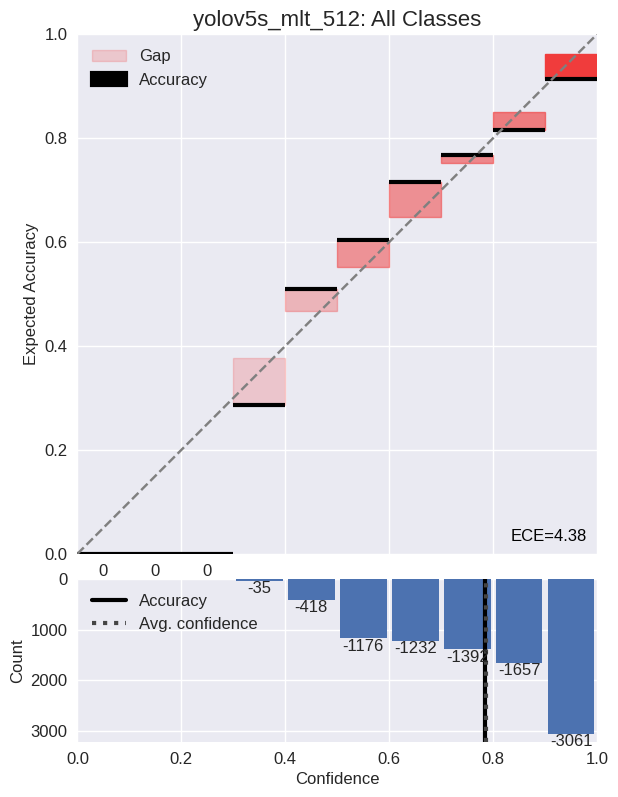

In [71]:
y_true = test_results_df.test_gt.values
y_pred = test_results_df.test_pred.values
y_conf = test_results_df.test_prob.values
plot_name = model.__class__.__name__

# Override matplotlib default styling.
plt.style.use("seaborn")

plt.rc("font", size=12)
plt.rc("axes", labelsize=12)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)
plt.rc("legend", fontsize=12)

plt.rc("axes", titlesize=16)
plt.rc("figure", titlesize=16)

title = "\n".join(plot_name.split()) + ': All Classes'

fig = reliability_diagram(y_true, y_pred, y_conf, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title=title, figsize=(6, 6), dpi=100, 
                          return_fig=True)
#fig.figure.savefig("output.png")
# path_to_img = f"{curr_dir}"
# im = plt.imread('output.png')
# wandb.log({"Reliability_diagram_Uncalibrated": [wandb.Image(im)]})

In [72]:
def plot_relibaility_each_class(class_number, df, calibrated=False):
    """
    class_number: the value of the class we want to plot 
    df is the dataframe containing the data
    calibrated: whether the model is calibrated or not
    """
    class_df_gt = df[df['test_gt'] == class_number]
    y_true = class_df_gt.test_gt.values
    y_pred = class_df_gt.test_pred.values
    y_conf = class_df_gt.test_prob.values
    plot_name = model.__class__.__name__ 

    # Override matplotlib default styling.
    plt.style.use("seaborn")

    plt.rc("font", size=12)
    plt.rc("axes", labelsize=12)
    plt.rc("xtick", labelsize=12)
    plt.rc("ytick", labelsize=12)
    plt.rc("legend", fontsize=12)

    plt.rc("axes", titlesize=16)
    plt.rc("figure", titlesize=16)

    title = "\n".join(plot_name.split()) + "\n" + 'Class = ' + str(class_names[class_number]) + ' (' + str(class_number) + ')' + "\n" + 'Calibrated:=' + str(calibrated)
    fig = reliability_diagram(y_true, y_pred, y_conf, num_bins=10, draw_ece=True,
                              draw_bin_importance="alpha", draw_averages=True,
                              title=title, figsize=(6, 6), dpi=100, 
                              return_fig=True)
#     fig.figure.savefig("output.png")
    # path_to_img = f"{curr_dir}"
#     im = plt.imread('output.png')
#     cal = 'uncalibrated'
#     if calibrated:
#         cal = 'calibrated'
#     title_wandb = "reliability_diagram_per_class_" + cal
#     wandb.log({title_wandb: [wandb.Image(im)]})

/tmp/ipykernel_22694/2987261591.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")
/tmp/ipykernel_22694/472109036.py:170: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


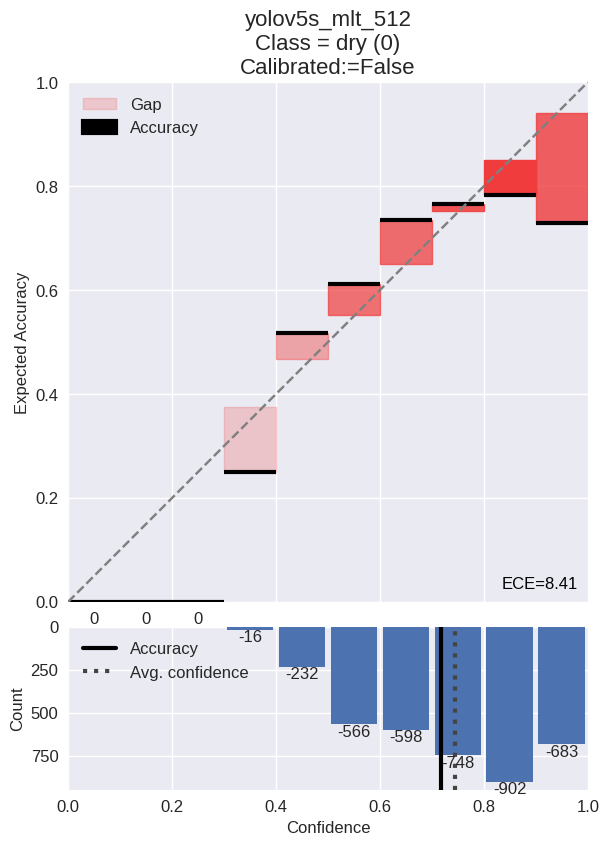

/tmp/ipykernel_22694/2987261591.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")
/tmp/ipykernel_22694/472109036.py:170: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


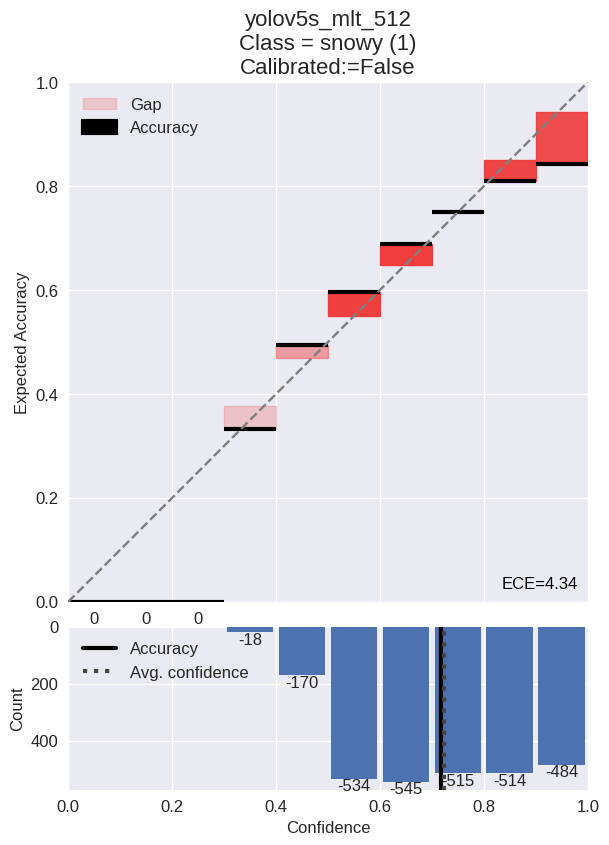

/tmp/ipykernel_22694/2987261591.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")
/tmp/ipykernel_22694/472109036.py:170: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


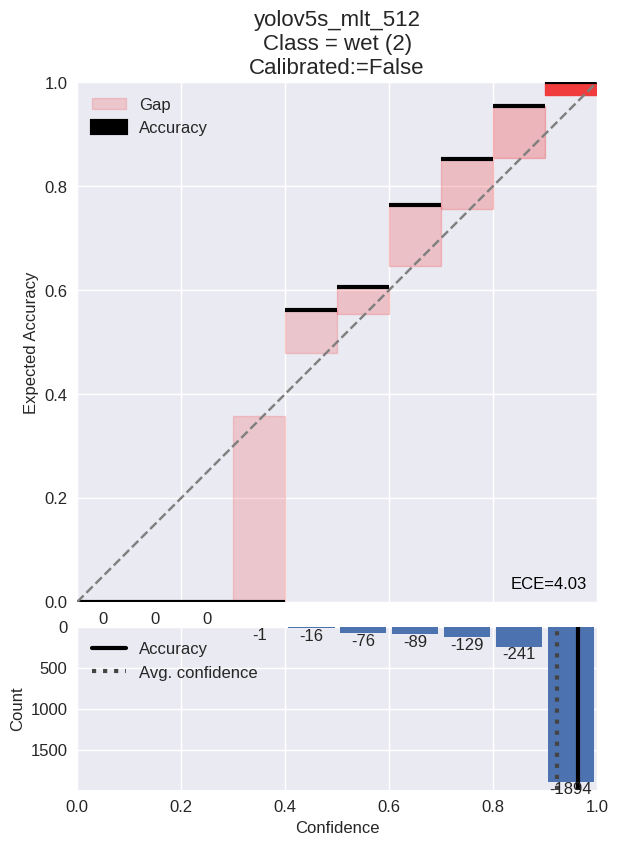

In [73]:
for i in range(len(class_names)):
    plot_relibaility_each_class(i,df=test_results_df)

----------------

## Calibration of the model 

I had some cuda issues while trying to use this algorithm to calibrate yolo-mlt. I did encounter some similar issues when calibrating other models and I solved it by simply reducing the maximimum number of iterations of the optimizer while with yolo, this solution does not seem to work. I haven't spend time fixing that but I'm sure it's possible and shouldn't be hard at all, it's just not the priority right now. As alternative, I simply manually tested different temperature values and visualized the resulting calibration plots. After a few iterations, I chose temperature=3. We can see on the plots above that this value calibrates the yolo-mlt classification output pretty well using the validation set of esmart_context.


I keep it here in case we want to focus on that later.

Temperature scaling because it has been proven that it is the easiest to implement and the most performant: https://arxiv.org/abs/1706.04599

In [18]:
# code from https://github.com/gpleiss/temperature_scaling
class ModelWithTemperature(nn.Module):
    """
    A thin decorator, which wraps a model with temperature scaling
    model (nn.Module):
        A classification neural network
        NB: Output of the neural network should be the classification logits,
            NOT the softmax (or log softmax)!
    """
    def __init__(self, model):
        super(ModelWithTemperature, self).__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1) * 1)

    def forward(self, input):
        output = self.model(input)
        preds, logits = output[0][0][0], output[0][1]
        return self.temperature_scale(logits)

    def temperature_scale(self, logits):
        """
        Perform temperature scaling on logits
        """
        # Expand temperature to match the size of logits
        temperature = self.temperature.unsqueeze(1).expand(logits.size(0), logits.size(1))
        return logits / temperature

    # This function probably should live outside of this class, but whatever
    def set_temperature(self, valid_loader):
        """
        Tune the tempearature of the model (using the validation set).
        We're going to set it to optimize NLL.
        valid_loader (DataLoader): validation set loader
        """
        self.cuda()
        nll_criterion = nn.CrossEntropyLoss().cuda()
        ece_criterion = _ECELoss().cuda()

        # First: collect all the logits and labels for the validation set
        logits_list = []
        labels_list = []
        from tqdm import tqdm
        with torch.no_grad():
            #for input, label in valid_loader:
            pbar = tqdm(valid_loader, bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')  # progress bar
            for batch_i, (input, targets_det, label, det_to_check, paths, shapes) in enumerate(pbar):
                input = input.float() / 255
                input = input.to(device, non_blocking=True)
                output = self.model(input)
                preds, logits = output[0][0][0], output[0][1]
                logits_list.append(logits)
                labels_list.append(label)
            logits = torch.cat(logits_list).cuda()
            labels = torch.cat(labels_list).cuda()

        # Calculate NLL and ECE before temperature scaling
        before_temperature_nll = nll_criterion(logits, labels).item()
        before_temperature_ece = ece_criterion(logits, labels)[0].item()
        print('Before temperature - NLL: %.3f, ECE: %.3f' % (before_temperature_nll, before_temperature_ece))

        # Next: optimize the temperature w.r.t. NLL
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

        def eval():
            optimizer.zero_grad()
            loss = nll_criterion(self.temperature_scale(logits), labels)
            loss.backward()
            return loss
        optimizer.step(eval)
        
        # apply the temperature scaling
        scaled_logits = self.temperature_scale(logits)
        # Calculate NLL and ECE after temperature scaling
        after_temperature_nll = nll_criterion(scaled_logits, labels).item()
        after_temperature_ece, conf, pred = ece_criterion(scaled_logits, labels)
        after_temperature_ece = after_temperature_ece.item()
        
        print('Optimal temperature: %.3f' % self.temperature.item())        
        print('After temperature - NLL: %.3f, ECE: %.3f' % (after_temperature_nll, after_temperature_ece))
        
        softmaxed = torch.nn.functional.softmax(scaled_logits, dim=1)
        scaled_conf = softmaxed.max(dim=1).values.detach().cpu().numpy()

        return torch.cat(labels_list).numpy(), pred.detach().cpu().numpy(), scaled_conf


class _ECELoss(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).
    The input to this loss is the logits of a model, NOT the softmax scores.
    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:
    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |
    We then return a weighted average of the gaps, based on the number
    of samples in each bin
    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=15):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece, confidences, predictions

In [2]:
model_with_temperature = ModelWithTemperature(model)
labels_list, pred, conf_scaled = model_with_temperature.set_temperature(val_dataloader)
# model_filename = os.path.join(save, 'model_with_temperature.pth')
# torch.save(model.state_dict(), model_filename)
# print('Temperature scaled model sved to %s' % model_filename)
print('Done! The model has been calibrated using temperature scaling.')

In [ ]:
!nvidia-smi

In [ ]:
model_filename = os.path.join('/home/selim/Desktop/yolov5_multitask/runs/train-cls/exp17/weights/', 'model_with_temperature.pt')
torch.save(model_with_temperature.state_dict(), model_filename)
print('Temperature scaled model saved to %s' % model_filename)

In [ ]:
test_results_df_calibrated = pd.DataFrame()
test_results_df_calibrated['test_gt'] = labels_list
test_results_df_calibrated['test_pred'] = pred
test_results_df_calibrated['test_prob'] = conf_scaled
test_results_df_calibrated.head()

## Inspect the calibration of the calibrated model

In [ ]:
plot_name = model.__class__.__name__

# Override matplotlib default styling.
plt.style.use("seaborn")

plt.rc("font", size=12)
plt.rc("axes", labelsize=12)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)
plt.rc("legend", fontsize=12)

plt.rc("axes", titlesize=16)
plt.rc("figure", titlesize=16)

title = "\n".join(plot_name.split()) + "\n" + 'All Classes'+ "\n" + 'Calibrated=True'

fig = reliability_diagram(labels_list, pred, conf_scaled, num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title=title, figsize=(6, 6), dpi=100, 
                          return_fig=True)
# fig.figure.savefig("output.png")
# # path_to_img = f"{curr_dir}"
# im = plt.imread('output.png')
# wandb.log({"Reliability_diagram_Calibrated": [wandb.Image(im)]})

In [ ]:
for i in range(len(class_names)):
    plot_relibaility_each_class(i,test_results_df_calibrated, calibrated=True)

## Visualize the difference of confidence between the calibrated model and the uncalibrated one

In [ ]:
# calibrated conf
calibrated_conf = test_results_df_calibrated.test_prob
# uncalibrated conf
uncalibrated_conf = test_results_df.test_prob
# difference 
difference_conf = calibrated_conf - uncalibrated_conf
difference_conf_df = pd.DataFrame(difference_conf)
difference_conf_df.head()

In [ ]:
to_plot = difference_conf_df[difference_conf_df.index.isin(range(0,100))]
# to_plot.head()

In [ ]:
fig = px.line(to_plot, y="test_prob", 
             title='Difference of confidence between the uncalibrated and calibrated models (100 first samples)')

fig.show()

## Results Metrics

In [ ]:
print(test_results_df_calibrated.shape)
test_results_df_calibrated.head()

### Filter the predictions

In [ ]:
# choose the individual thresholds by analysing the reliability diagrams 
above_threshold = test_results_df_calibrated[
    (test_results_df_calibrated['test_pred'] == 0) & (test_results_df_calibrated['test_prob'] >= 0.7) |
    (test_results_df_calibrated['test_pred'] == 1) & (test_results_df_calibrated['test_prob'] >= 0.8) |
    (test_results_df_calibrated['test_pred'] == 2) & (test_results_df_calibrated['test_prob'] >= 0.5)
] 

# or choose a single threshold
# CONF_THRESHOLD = 0.88
# above_threshold = test_results_df[test_results_df['test_prob'] >= CONF_THRESHOLD]

print(above_threshold.shape)
above_threshold.head()

In [ ]:
confusion_matrix = pd.crosstab(above_threshold['test_gt'], 
                               above_threshold['test_pred'], 
                               rownames=['Actual'], 
                               colnames=['Pred']
                              )
column_names = {}
for i, name in enumerate(class_names):
        column_names[i]=name
confusion_matrix = confusion_matrix.rename(columns=column_names, index=column_names)
confusion_matrix